# Test Evaluation

add 4 other models from notebook 6 and 7

In [1]:
%cd '../'

/Users/clemencegranade/Documents/ift6758 - DS/group_proj1/IFT6758


# AdaBoostClassifier

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from ift6758.pipeline import ExperimentPipeline, DEFAULT_TRANSFORMATIONS

pipelineAdaBoost = ExperimentPipeline(
    tabular_dir='./ift6758/data/tabular',
    dataset_partition='stratified',
    feature_columns=[
        'shot_distance',
        'shot_angle',
        'dist_prev_event',
        'time_lapsed_prev_event_in_seconds',
        'game_secs'
    ],
    model_save_directory="./ift6758/data/models",
    target_column='goal',
    pipeline_steps=[
        (
            'adaboost',
            AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(max_depth=3),
                learning_rate=0.1,
                n_estimators=75
            )
        ),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid={},
    metric='roc_auc',
    test_season=20192020
)

In [54]:
pipelineAdaBoost.run()

fetching dataframes from ift6758/data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.746 total time=  28.7s
[CV 2/5] END ..................................., score=0.741 total time=  34.0s


# XGB

In [14]:
from xgboost import XGBClassifier

pipelineXGB = ExperimentPipeline(
    tabular_dir='./ift6758/data/tabular',
    dataset_partition='stratified',
    feature_columns=['shot_distance', 'shot_angle', 'dist_prev_event', 'time_lapsed_prev_event_in_seconds', 'game_secs'],

    model_save_directory="./ift6758/data/models",
    target_column='goal',
    pipeline_steps=[
        (
            'xgb_model',
            XGBClassifier(
                objective='binary:logistic',
            )
        ),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[{
        'xgb_model__objective':['binary:logistic'],
        'xgb_model__learning_rate': [0.2],
        'xgb_model__max_depth': [3],
        'xgb_model__min_child_weight': [1],
        'xgb_model__n_estimators': [100],
        'xgb_model__eval_metric': ['logloss']
    }],
    metric='roc_auc',
    test_season=20192020
)

# Log Models

In [8]:
from sklearn.linear_model import LogisticRegression

pipelineLogDist = ExperimentPipeline(
    tabular_dir='./ift6758/data/tabular',
    model_save_directory="./ift6758/data/models",
    feature_columns=['shot_distance'],
    target_column='goal',
    pipeline_steps=[
        ('logreg', LogisticRegression()),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    metric='accuracy',
    enable_comet=False,
    test_season=20192020
)

pipelineLogAngle = ExperimentPipeline(
    tabular_dir='./ift6758/data/tabular',
    model_save_directory="./ift6758/data/models",
    feature_columns=['shot_angle'],
    target_column='goal',
    pipeline_steps=[
        ('logreg', LogisticRegression()),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    metric='accuracy',
    enable_comet=False,
    test_season=20192020
)

pipelineLogDistAngle = ExperimentPipeline(
    tabular_dir='./ift6758/data/tabular',
    model_save_directory="./ift6758/data/models",
    feature_columns=['shot_distance', 'shot_angle'],
    target_column='goal',
    pipeline_steps=[
        ('logreg', LogisticRegression()),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    metric='accuracy',
    enable_comet=False,
    test_season=20192020
)

fetching dataframes from ift6758/data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
fetching dataframes from ift6758/data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.746 total time=  40.6s
[CV 2/5] END ..................................., score=0.742 total time=  43.1s
[CV 3/5] END ..............................

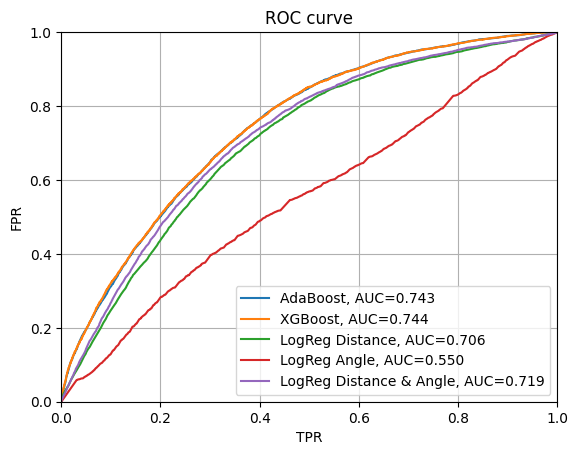

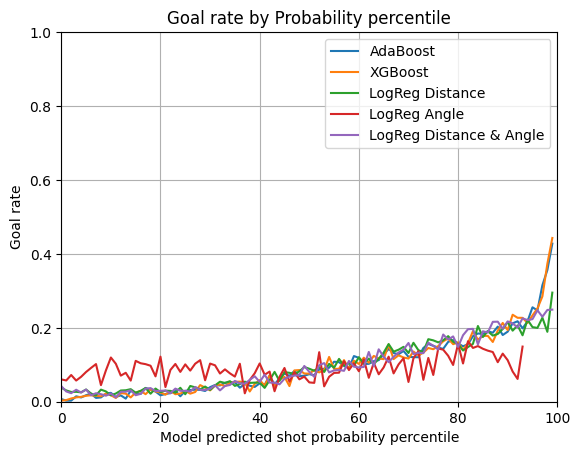

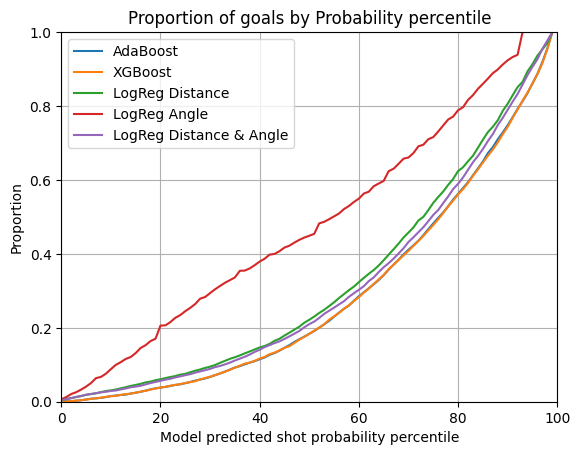

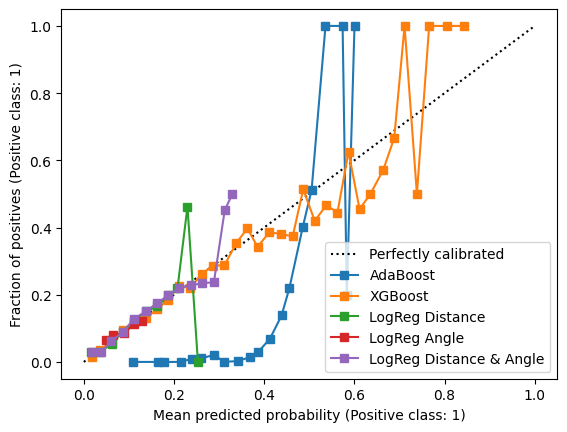

In [15]:
from ift6758.pipeline.plots import *

truth, probas, labels = [], [], ['AdaBoost', 'XGBoost', 'LogReg Distance', 'LogReg Angle', 'LogReg Distance & Angle']
truth_playoffs, probas_playoffs, labels_playoffs = [], [], ['AdaBoost', 'XGBoost', 'LogReg Distance', 'LogReg Angle', 'LogReg Distance & Angle']

df_playoffs = ExperimentPipeline.get_data('./ift6758/data/tabular', playoffs=True, reg=False, years=[20192020], transformations=DEFAULT_TRANSFORMATIONS)

pipeline = None
for pipe_hold in [
    pipelineAdaBoost,
    pipelineXGB,
    pipelineLogDist,
    pipelineLogAngle,
    pipelineLogDistAngle,
]:
    pipeline = pipe_hold
    pipeline.run()

    df_x, df_y = pipeline.dataset['x_test'], pipeline.dataset['y_test']

    pipeline.dataset['x_test'], pipeline.dataset['y_test'] = df_x, df_y
    truth.append(pipeline.dataset['y_test'])
    probas.append(pipeline.get_probas('test'))

    pipeline.dataset['x_test'], pipeline.dataset['y_test'] = df_playoffs[pipeline.feature_columns], df_playoffs['goal']
    truth_playoffs.append(pipeline.dataset['y_test'])
    probas_playoffs.append(pipeline.get_probas('test'))

plot_all(truth, probas, labels)

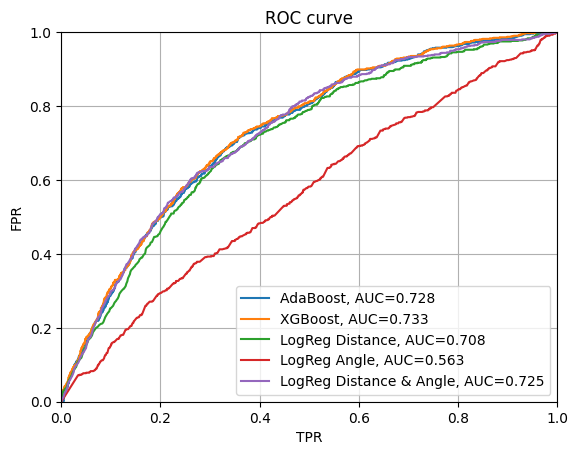

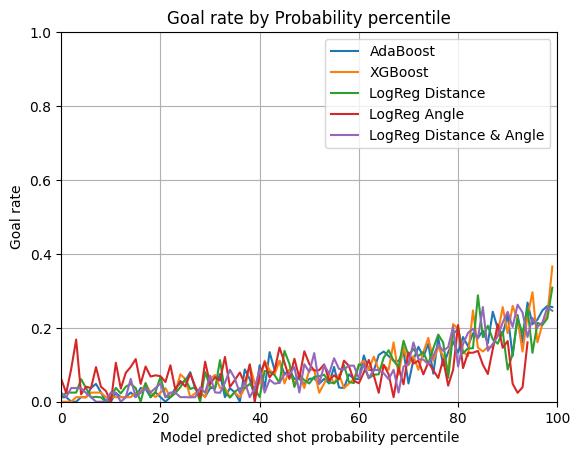

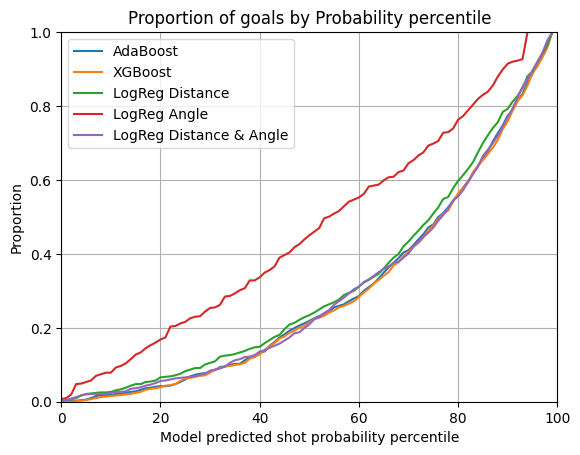

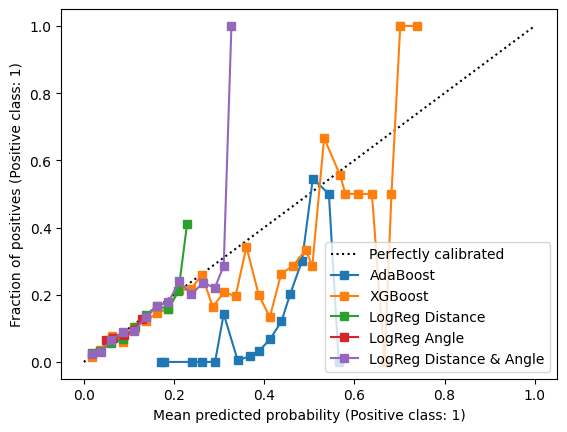

In [16]:
plot_all(truth_playoffs, probas_playoffs, labels_playoffs)